In [1063]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Predict risk score


#### 1. Data cleaning and preparation

In [1064]:
# URL to the data
data_url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

# Function to download the data
def download_data(data):
    r = requests.get(data)
    with open('CreditScoring.csv', 'wb') as f:
        f.write(r.content)
    return 'CreditScoring.csv'

# Function to load the data
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Download and load the data
file_path = download_data(data_url)
df = pd.DataFrame(load_data(file_path))

# Display the DataFrame
df.head()


,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [1065]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [1066]:
df.dtypes

status       int64
seniority    int64
home         int64
time         int64
age          int64
marital      int64
records      int64
job          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
dtype: object

change some variables that are categorical values but in here they are integers.

In [1067]:
status_values = {1: 'ok',
                2: 'default',
                0: 'unk'}

df.status = df.status.map(status_values)

In [1068]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [1069]:
df.describe().round(2)


,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00
mean,7.99,46.44,37.08,55.57,763316.99,1060340.81,404381.96,1039.02,1462.88
std,8.17,14.66,10.98,19.52,8703625.26,10217568.67,6344253.40,474.54,628.09
min,0.00,6.00,18.00,35.00,0.00,0.00,0.00,100.00,105.00
25%,2.00,36.00,28.00,35.00,80.00,0.00,0.00,700.00,1117.50
50%,5.00,48.00,36.00,51.00,120.00,3500.00,0.00,1000.00,1400.00
75%,12.00,60.00,45.00,72.00,166.00,6000.00,0.00,1300.00,1692.00
max,48.00,72.00,68.00,180.00,99999999.00,99999999.00,99999999.00,5000.00,11140.00


we see that in income, assets and debt we have 99999999 that in the documentation of the database we see they are nulls. so lets replace.

In [1070]:
# max_income = df.income.max()
# print(max_income)
# max_assets = df.assets.max()
# max_debt = df.debt.max()
# df.income = df.income.replace(to_replace=max_income, value=0)
# df.assets = df.assets.replace(to_replace=max_assets, value=0)
# df.debt = df.debt.replace(to_replace=max_debt, value=0)

In [1071]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [1072]:
df.describe().round(2)

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.00,4455.00,4455.00,4455.00,4421.00,4408.00,4437.00,4455.00,4455.00
mean,7.99,46.44,37.08,55.57,130.57,5403.43,342.95,1039.02,1462.88
std,8.17,14.66,10.98,19.52,86.37,11573.16,1245.86,474.54,628.09
min,0.00,6.00,18.00,35.00,0.00,0.00,0.00,100.00,105.00
25%,2.00,36.00,28.00,35.00,80.00,0.00,0.00,700.00,1117.50
50%,5.00,48.00,36.00,51.00,120.00,3000.00,0.00,1000.00,1400.00
75%,12.00,60.00,45.00,72.00,165.00,6000.00,0.00,1300.00,1692.00
max,48.00,72.00,68.00,180.00,959.00,300000.00,30000.00,5000.00,11140.00


In [1073]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

in status we see there are 1 unknown, lets remove it

In [1074]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [1075]:
df.status.value_counts()

status
ok         3200
default    1254
Name: count, dtype: int64

split test and validation

In [1076]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [1077]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Encode properly the target and create a new df for it in train, val and test

In [1078]:
y_train = (df_train.status == 'default').astype(int)
y_val = (df_val.status == 'default').astype(int)
y_test = (df_test.status == 'default').astype(int)


remove target variables from dataframe

In [1079]:
del df_train['status']
del df_val['status']
del df_test['status']

#### 2. Decision trees

In [1080]:
def asses_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'partime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [1081]:
xi = df_train.iloc[0].to_dict()

In [1082]:
asses_risk(xi)

'ok'

In [1083]:
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [1084]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [1085]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts) 


In [1086]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [1087]:
dt = DecisionTreeClassifier()   
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [1088]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [1089]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [1090]:
roc_auc_score(y_val, y_pred)

0.6591297134968879

lets see what is the auc score for our training dataset

In [1091]:
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]])

In [1092]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

this is overfitting.

In [1093]:
dt = DecisionTreeClassifier(max_depth=3)   
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [1094]:
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:',auc)
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:',auc)

val: 0.7389079944782155
train: 0.7761016984958594


to see the trees

In [1095]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names_out()))    

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



----------------------------------------------------------------------------

Simple example
-------------------------------

In [1096]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [1097]:
df_example.sort_values(by='assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [1098]:
Ts = [2000, 3000, 4000, 5000, 8000]

In [1099]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



now we hve to find the best between all splits  
to know which is the best we use the missclassification rate

In [1100]:
print(df_left.status.value_counts(normalize=True))

status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


In [1101]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [1102]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [1103]:
for Feature, Ts in thresholds.items():
    print('#######################')
    print(Feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[Feature] <= T]
        df_right = df_example[df_example[Feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

    print()

#######################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#######################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64



----------------------------------------------------------------------------

### Decision tree parameters tunning

selection of max_depth & min_samples_leaf that are the more important

In [1104]:
depth_list = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
for d in depth_list:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))


   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.759
  10 -> 0.692
  15 -> 0.662
  20 -> 0.669
None -> 0.647


In [1105]:
scores = []

for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [1106]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
51,10.0,15,0.790093
67,20.0,15,0.789104
59,15.0,15,0.788725
75,NaN,15,0.787378
43,6.0,15,0.785695
...,...,...,...
4,1.0,20,0.605864
3,1.0,15,0.605864
1,1.0,5,0.605864
2,1.0,10,0.605864


In [1107]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='auc').round(3)
df_scores_pivot

max_depth,NaN,1.0,2.0,3.0,4.0,5.0,6.0,10.0,15.0,20.0
min_samples_leaf,,,,,,,,,,
1,0.655,0.606,0.669,0.739,0.761,0.766,0.762,0.694,0.657,0.654
5,0.723,0.606,0.669,0.739,0.761,0.768,0.761,0.734,0.717,0.713
10,0.762,0.606,0.669,0.739,0.761,0.762,0.778,0.767,0.764,0.759
15,0.787,0.606,0.669,0.738,0.764,0.772,0.786,0.790,0.789,0.789
20,0.783,0.606,0.669,0.736,0.761,0.774,0.774,0.784,0.782,0.784
100,0.780,0.606,0.669,0.736,0.756,0.763,0.776,0.780,0.780,0.780
200,0.768,0.606,0.669,0.729,0.747,0.759,0.768,0.768,0.768,0.768
500,0.680,0.620,0.680,0.680,0.680,0.680,0.680,0.680,0.680,0.680


<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

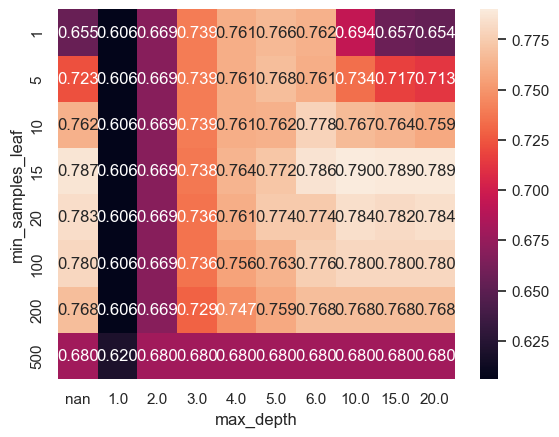

In [1108]:
import seaborn as sns
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")


try the final decision tree

In [1109]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)


val: 0.7848562640769174


### Random Forest

In [1110]:
from sklearn.ensemble import RandomForestClassifier

In [1111]:
rf = RandomForestClassifier(n_estimators=100,random_state= 1) # 10 trees
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [1112]:
y_pred = rf.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

val: 0.8156650359642538


In [1113]:
rf.predict_proba(X_val[[0]])

array([[0.77, 0.23]])

In [1114]:
scores = []
for n in range(10, 201, 10):   
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

In [1115]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])


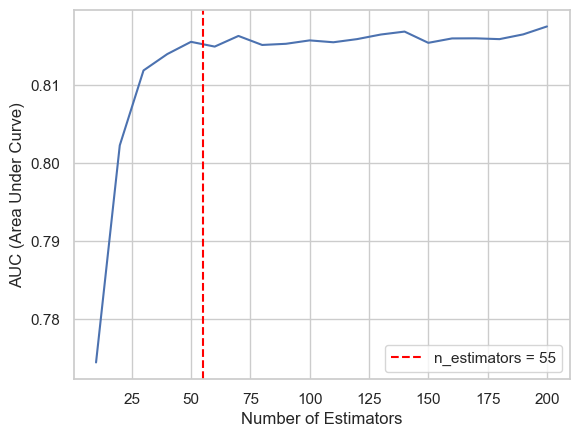

In [1116]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.ticker import FuncFormatter

sns.set(style='whitegrid')
ax = sns.lineplot(x='n_estimators', y='auc', data=df_scores)

 
def format_auc(value, tick_number):
    return f"{value:.2f}"  # Format as 2 decimal places

ax.yaxis.set_major_formatter(FuncFormatter(format_auc))
 
ax.set_xlabel("Number of Estimators", fontsize=12)
ax.set_ylabel("AUC (Area Under Curve)", fontsize=12)
 
plt.axvline(x=55, color='red', linestyle='--', label='n_estimators = 55')
 
plt.legend()
 
plt.show()

lets also add max_depht and min_sample_size

In [1117]:
scores = []
for d in [5, 10, 15]:

    for n in range(10, 201, 10):   
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d, 
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [1118]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878
5,5,60,0.801167
6,5,70,0.802203
7,5,80,0.803238
8,5,90,0.803447
9,5,100,0.804385


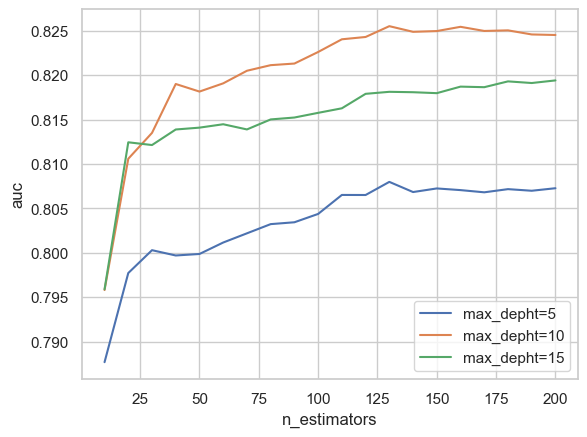

In [1119]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]

    sns.set(style='whitegrid')
    sns.lineplot(x='n_estimators', y='auc',  label='max_depht=%d' % d, data=df_subset)

 
    def format_auc(value, tick_number):
        return f"{value:.2f}"  # Format as 2 decimal places

    ax.yaxis.set_major_formatter(FuncFormatter(format_auc))
    
    ax.set_xlabel("Number of Estimators", fontsize=12)
    ax.set_ylabel("AUC (Area Under Curve)", fontsize=12)
     
    
    plt.legend() 
     

In [1120]:
max_depht = 10

In [1121]:
scores = []
for s in [1, 3, 5, 10, 20, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depht,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [1122]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])
df_scores

,min_samples_leaf,n_estimators,auc
0,1,10,0.795818
1,1,20,0.810597
2,1,30,0.813510
3,1,40,0.819013
4,1,50,0.818160
...,...,...,...
115,50,160,0.806020
116,50,170,0.805191
117,50,180,0.805094
118,50,190,0.805427


In [1123]:
color = ['red', 'blue', 'green', 'yellow', 'black', 'purple']
min_samples_leaf = [1, 3, 5, 10, 20, 50]
list(zip(min_samples_leaf, color))

[(1, 'red'),
 (3, 'blue'),
 (5, 'green'),
 (10, 'yellow'),
 (20, 'black'),
 (50, 'purple')]

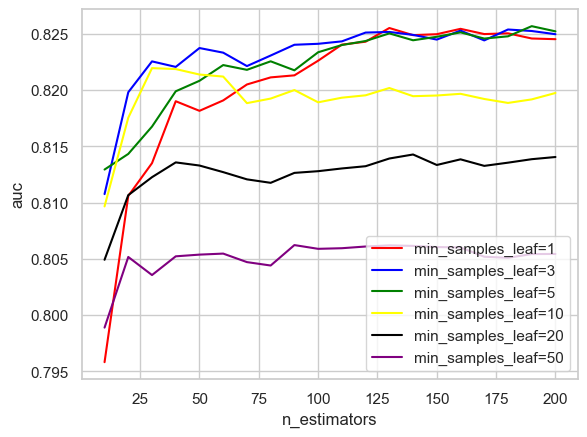

In [1124]:

for s, col in zip(min_samples_leaf, color):
    df_subset = df_scores[df_scores.min_samples_leaf == s]

    sns.set(style='whitegrid')
    sns.lineplot(x='n_estimators', y='auc',  label='min_samples_leaf=%d' % s,color=col, data=df_subset)

 
    def format_auc(value, tick_number):
        return f"{value:.2f}"  # Format as 2 decimal places

    ax.yaxis.set_major_formatter(FuncFormatter(format_auc))
    
    ax.set_xlabel("Number of Estimators", fontsize=12)
    ax.set_ylabel("AUC (Area Under Curve)", fontsize=12)
     
    
    plt.legend()

In [1125]:
min_samples_leaf = 3

In [1126]:
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depht, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc.round(3))


val: 0.825


another interesting parameters  
- max_feature (how many randomly selected features)
- boostrap_ another way of randomisation
- n jobs: number of trees trained in paralelñ. -1 all at onc

### Gradient boosting and XGboost

In [1127]:
#pip install xgboost
import xgboost as xgb


In [1128]:
# structure of the data for Xgboos: allows to train faster the model
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [1129]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1, # same as min_samples_leaf
    'objective': 'binary:logistic', # binary logistic regression
    'nthread': 8, # number of threads
    'seed': 1, # random seed
    'verbosity': 1 # control the warning messages. 1 means most of the messages are printed
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [1130]:
model.predict(dval)
# returns 1 dimensional array with the probability of default

array([3.43261696e-02, 6.90845598e-04, 3.03691556e-03, 9.81778800e-02,
       8.90289521e-05, 1.03314058e-03, 1.35689916e-03, 2.69821912e-01,
       3.84416759e-01, 8.63076712e-05, 7.33646080e-02, 9.92994249e-01,
       6.40794039e-01, 3.32895172e-04, 6.42735325e-03, 9.80152786e-01,
       2.66226736e-04, 7.69769967e-01, 1.41964701e-03, 8.05914029e-02,
       1.74170651e-03, 1.56251296e-01, 1.30674313e-03, 8.88928175e-01,
       8.21285784e-01, 1.23773478e-02, 6.90062523e-01, 1.81131959e-02,
       9.05059397e-01, 7.21748802e-04, 9.96741235e-01, 5.74891686e-01,
       2.90193204e-02, 1.20363638e-01, 1.37569601e-04, 2.51046822e-05,
       9.99943376e-01, 1.12876602e-01, 9.11785781e-01, 7.27639198e-01,
       7.15358462e-03, 9.93663073e-01, 3.82073200e-03, 5.16633451e-01,
       8.45008835e-05, 7.53858068e-04, 4.14075822e-01, 1.29025511e-03,
       1.24535533e-02, 3.70233203e-03, 2.21459879e-04, 5.64254001e-02,
       1.18297443e-03, 2.00369447e-01, 7.03067243e-01, 8.99023637e-02,
      

In [1131]:
roc_auc_score(y_val, model.predict(dval))

0.8072491584122448

monitor the performance of the training procedure. After new tree is created we can see the results by adding  watchlist to see the value

In [1132]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [1133]:
# see it in the plot the training resuts we can use this to capture the outputs as is not easy to see the results. we call the results output here
%%capture output_captured

xgb_params = {
    'eta': 0.05, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic', 
    'eval_metric': 'auc',# to evaluate the model

    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200, 
                  verbose_eval=5, # print every 5 rounds and not every round
                  evals=watchlist)

UsageError: Line magic function `%%capture` not found.


In [1134]:
s = output_captured.stdout
s

'[0]\ttrain-auc:0.86730\tval-auc:0.77938\n[5]\ttrain-auc:0.93086\tval-auc:0.80858\n[10]\ttrain-auc:0.95447\tval-auc:0.80851\n[15]\ttrain-auc:0.96554\tval-auc:0.81334\n[20]\ttrain-auc:0.97464\tval-auc:0.81729\n[25]\ttrain-auc:0.97953\tval-auc:0.81686\n[30]\ttrain-auc:0.98579\tval-auc:0.81543\n[35]\ttrain-auc:0.99011\tval-auc:0.81206\n[40]\ttrain-auc:0.99421\tval-auc:0.80922\n[45]\ttrain-auc:0.99548\tval-auc:0.80842\n[50]\ttrain-auc:0.99653\tval-auc:0.80918\n[55]\ttrain-auc:0.99765\tval-auc:0.81114\n[60]\ttrain-auc:0.99817\tval-auc:0.81172\n[65]\ttrain-auc:0.99887\tval-auc:0.80798\n[70]\ttrain-auc:0.99934\tval-auc:0.80870\n[75]\ttrain-auc:0.99965\tval-auc:0.80555\n[80]\ttrain-auc:0.99979\tval-auc:0.80549\n[85]\ttrain-auc:0.99988\tval-auc:0.80374\n[90]\ttrain-auc:0.99993\tval-auc:0.80409\n[95]\ttrain-auc:0.99996\tval-auc:0.80548\n[100]\ttrain-auc:0.99998\tval-auc:0.80509\n[105]\ttrain-auc:0.99999\tval-auc:0.80629\n[110]\ttrain-auc:1.00000\tval-auc:0.80637\n[115]\ttrain-auc:1.00000\tval-au

In [1135]:
line_output = s.split('\n')[0]# split the string into a list of strings
line_output

'[0]\ttrain-auc:0.86730\tval-auc:0.77938'

In [1136]:
num_iter,train_auc, val_auc = line_output.split('\t') # split the string into a list of strings

In [1137]:
print('before change num_iter:',num_iter)
num_iter = int(num_iter.strip('[]'))# split the string into a list of strings
print('after change num_iter:',num_iter)

before change num_iter: [0]
after change num_iter: 0


In [1138]:
print('before change train_auc:',train_auc)
train_auc = float(train_auc.split(':')[1])# split the string into a list of strings
print('after change train_auc:',train_auc)

before change train_auc: train-auc:0.86730
after change train_auc: 0.8673


In [1139]:
val_auc = float(val_auc.split(':')[1])# split the string into a list of strings

In [1140]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [1141]:
df_score = parse_xgb_output(output_captured)
df_score

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
7,35,0.99011,0.81206
8,40,0.99421,0.80922
9,45,0.99548,0.80842


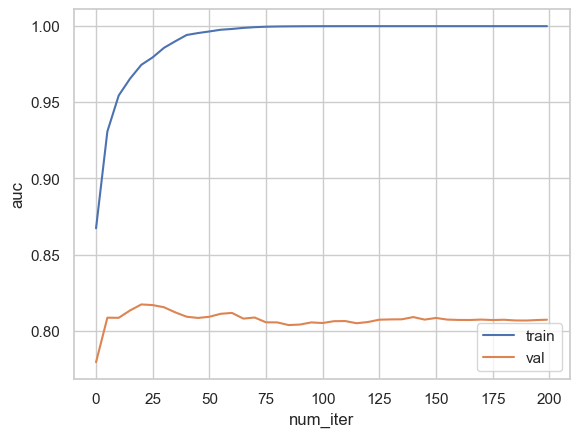

In [1142]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')

plt.xlabel('num_iter')
plt.ylabel('auc')
plt.legend()


when trin reches the perfection we see the overfitting effect on val.

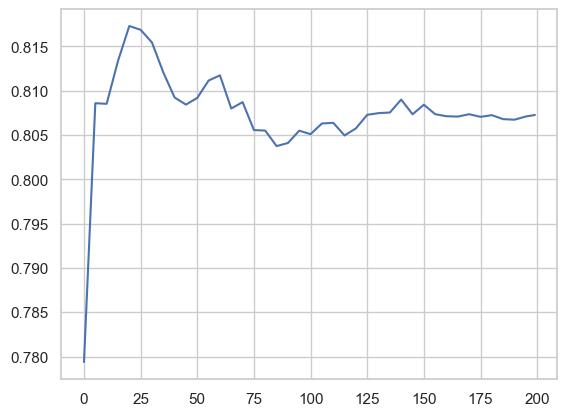

In [1143]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')


with default parameters, around 25 trees we got the best performace and get around 82% of AUC

### Tune parameters in XGBoost model

1. learning rate (eta) is the most impotant parameter in this model
2. Max depht
3. mild child weight

In [1144]:
scores = {}

In [1145]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200, 
                  verbose_eval=5, # print every 5 rounds and not every round
                  evals=watchlist) 


In [1146]:
'eta=%s' % xgb_params['eta']

'eta=0.05'

In [1147]:
key = 'eta=%s' % xgb_params['eta']
scores[key] = parse_xgb_output(output)
 

In [1148]:
scores.keys()

dict_keys(['eta=0.05'])

In [1149]:
# etas = ['eta=0.1', 'eta=0.3','eta=1.0']
# # print the scores
# for key, df_score in scores.items(): 
#     plt.plot(df_score.num_iter, df_score.val_auc, label=key)
# plt.legend()


In [1150]:
# etas = ['eta=0.1', 'eta=0.3', 'eta=0.01' ,'eta=0.05']

# for eta in etas:
#     plt.plot(scores[eta].num_iter, scores[eta].val_auc, label=eta)
# plt.legend()

0.1 is the best parameter as needs less iterations to reach the same as 0.05

In [1151]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200, 
                  verbose_eval=5, # print every 5 rounds and not every round
                  evals=watchlist) 


In [1152]:
key = 'max_depth=%s' % xgb_params['max_depth']
scores[key] = parse_xgb_output(output)
 

In [1153]:
# max_de = ['max_depth=6', 'max_depth=3', 'max_depth=4','max_depth=10']
# for md in max_de:
#     plt.plot(scores[md].num_iter, scores[md].val_auc, label=md)
# plt.ylim(0.8, 0.84)     
# plt.legend()

max_depth of 3 is the best

In [1154]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=200, 
                  verbose_eval=5, # print every 5 rounds and not every round
                  evals=watchlist) 


In [1155]:
key = 'min_child_weight=%s' % xgb_params['min_child_weight']
scores[key] = parse_xgb_output(output)
 

In [1156]:
# max_de = ['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30']
# for md in max_de:
#     plt.plot(scores[md].num_iter, scores[md].val_auc, label=md)
# plt.ylim(0.8, 0.84)     
# plt.legend()

final model

In [1157]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

there are other useful parameters
subsample: samples rows (getting only x% of the data per tree)
colsample_bytree:how many features per tree. by default uses 1.0 and we should try 0.6, 0.3.
lambda:
alpha:

### Selecting best model

In [1158]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [1159]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.785470804775859

In [1160]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [1161]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8249709379767989

In [1162]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [1163]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8309347073212081

XGBoost s the best model, so lets train final model and validate with test dataset

In [1164]:
df_full_train = df_full_train.reset_index(drop=True)

In [1165]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [1166]:
del df_full_train['status']

In [1167]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [1168]:
print(X_full_train.shape[1])  # Number of columns
print(len(dv.get_feature_names_out()))  # Number of feature names


29
29


In [1169]:
dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))


In [1170]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                   feature_names=list(dv.get_feature_names_out()))
dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [1171]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [1172]:
y_pred = model.predict(dtest)

In [1173]:
roc_auc_score(y_test, y_pred)

0.8289367577342261

In [1174]:
y_pred = model.predict(dtest)[:10]
y_pred

array([0.29601693, 0.231007  , 0.07417598, 0.27287328, 0.35843658,
       0.24473044, 0.00899626, 0.02323965, 0.24221162, 0.23622705],
      dtype=float32)